In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os

# Configurar Dask
dask.config.set({"dataframe.convert-string": False})
client = Client()

# Paths locales
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

In [2]:
# Cargar datos con Dask (solo 10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
# Usar 10% de los archivos
num_files_train = max(1, int(len(parquet_files_train) * 0.05))
parquet_files_train = parquet_files_train[:num_files_train]

train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')
print(f"Train cargado con {num_files_train} archivos (10% del total)")

parquet_files_test = glob(os.path.join(test_path, '**/part-*.parquet'), recursive=True)
num_files_test = max(1, int(len(parquet_files_test) * 0.05))
parquet_files_test = parquet_files_test[:num_files_test]

test_ddf = dd.read_parquet(parquet_files_test, engine='pyarrow')
print(f"Test cargado con {num_files_test} archivos (10% del total)")

Train cargado con 7 archivos (10% del total)
Test cargado con 4 archivos (10% del total)


In [3]:
# Exploración básica
train_sample = train_ddf.head(10)
test_sample = test_ddf.head(10)
print(f"Train columns: {train_ddf.columns.tolist()}")
print(f"Test columns: {test_ddf.columns.tolist()}")
display(train_sample.head())
display(test_sample.head())

Train columns: ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28', 'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration', 'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retentiond7', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'carrier', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'hour', 'release_date', 'release_msrp', 'weekday', 'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'city_hist', 'country_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'dev_language_hist', 'dev_osv_hist', 'first_request_ts', 'first_request_ts_bundle', 'first_request_ts_category_bottom_taxonomy', 'hour_ratio', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'iap_revenue_usd_category_bottom_taxonomy', 'last_

,buyer_d1,buyer_d7,buyer_d14,buyer_d28,buy_d7,buy_d14,buy_d28,iap_revenue_d7,iap_revenue_d14,iap_revenue_d28,...,user_bundles_l28d,weekend_ratio,weeks_since_first_seen,wifi_ratio,whale_users_bundle_num_buys_prank,whale_users_bundle_revenue_prank,whale_users_bundle_total_num_buys,whale_users_bundle_total_revenue,row_id,datetime
0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,...,"[6ef527966f9c636b063f5fc9825af795a0b7a726, 5c7...",0.076923,6.0,0.846154,None,None,None,None,564a4c37-9629-4eb6-ac3e-d2089e90d707,2025-10-01-09-00
1,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,...,"[7f95f51611579fcbdaf23548eea2d704d74e533f, 6b3...",0.353147,6.0,0.986888,None,None,None,None,7be43e26-8511-4b83-994d-e8b1e3430e6d,2025-10-01-09-00
2,1,1,1,1,1,1,1,11.728967,11.728967,11.728967,...,"[b7af822929c2927a9f886d36e5f35c23d08cb95b, 11d...",0.200061,6.0,0.759927,None,None,None,None,998fe788-5f52-4e80-aa5b-daf678e3d957,2025-10-01-09-00
3,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,...,"[a05f13a3b46d196edb8fb2b6a5511a012dbad18f, c38...",0.049020,6.0,0.637255,None,None,None,None,ddcf6619-bc68-4580-994b-bb605cb029e4,2025-10-01-09-00
4,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,...,"[5811ab45916e902c7f3e40f757a1476f0812deed, f46...",0.330337,4.0,0.877528,None,None,None,None,4908df9d-c244-4fd0-8823-82cb419e7669,2025-10-01-09-00


,advertiser_bundle,advertiser_category,advertiser_subcategory,advertiser_bottom_taxonomy_level,carrier,country,region,dev_make,dev_model,dev_os,...,user_bundles_l28d,weekend_ratio,weeks_since_first_seen,wifi_ratio,whale_users_bundle_num_buys_prank,whale_users_bundle_revenue_prank,whale_users_bundle_total_num_buys,whale_users_bundle_total_revenue,row_id,datetime
0,11d353b3a3bc2dc7db932d4ce7c4a8d18e3dc5f2,games,games/casual,match swap,None,br,None,apple,iphone 11,ios,...,"[50d27130d9864e7e1078b533c957a10529899078, c18...",0.0,6.0,0.714286,None,None,None,None,0831c6a0-e1f1-4a22-935a-9dc6a6a3e02c,2025-10-08-13-00
1,21926f7b2450e4b80d13b07667d6c0582bff7419,game,simulation,breeding,None,ph,None,generic,android 8.1,android,...,None,NaN,NaN,NaN,None,None,None,None,226a7db5-4224-415e-b3e7-30ead377dc43,2025-10-08-13-00
2,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,None,in,None,generic,android 13.0,android,...,None,NaN,NaN,NaN,None,None,None,None,e4e28b40-4c59-4ac5-ac29-fc53e587bbcd,2025-10-08-13-00
3,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,None,sa,None,realme,rmx1801,android,...,None,NaN,NaN,NaN,None,None,None,None,521c5f33-8e77-45c7-82c6-6136428d2761,2025-10-08-13-00
4,fcce26ae1abe348cb24c4f4e542957ef5d9773fd,social networking,entertainment,None,None,pk,None,infinix,x6526,android,...,"[b9c2a109b0a63f4bfcf40675a823de7052ef071c, 732...",1.0,1.0,1.000000,None,None,None,None,a9645541-5510-40fb-bda0-6366ba053c79,2025-10-08-13-00


In [4]:
# Preparar datos para LGBM (computar a Pandas)
train_df = train_ddf.compute(scheduler='synchronous')  # Usa menos memoria
test_df = test_ddf.compute(scheduler='synchronous')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (1026857, 85)
Test shape: (549453, 68)


In [5]:
# Definir labels a excluir y features
labels_to_exclude = ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28',
                     'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration',
                     'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14',
                     'retention_d1', 'retention_d3', 'retention_d7']

# Calcular porcentaje de missings por columna
missing_pct = train_df.isnull().sum() / len(train_df)
high_missing_cols = missing_pct[missing_pct > 0.7].index.tolist()

print(f"Columnas con >70% missings: {len(high_missing_cols)}")
print(f"Columnas a eliminar: {high_missing_cols}")

features = [col for col in train_df.columns 
            if col not in labels_to_exclude + ['row_id', 'datetime'] + high_missing_cols]

cat_features = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region',
                'dev_make', 'dev_model', 'dev_os', 'dev_osv']

print(f"Total features: {len(features)}")
print(f"Categorical features: {len(cat_features)}")

Columnas con >70% missings: 29
Columnas a eliminar: ['carrier', 'region', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'iap_revenue_usd_category_bottom_taxonomy', 'last_buy', 'last_buy_ts_bundle', 'last_buy_ts_category', 'last_ins', 'last_install_ts_bundle', 'last_install_ts_category', 'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp', 'last_advertiser_action', 'num_buys_bundle', 'num_buys_category', 'num_buys_category_bottom_taxonomy', 'rev_by_adv', 'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank', 'whale_users_bundle_total_num_buys', 'whale_users_bundle_total_revenue']
Total features: 38
Categorical features: 9


In [6]:
# Split time-based: train early, val late
# Ensure datetime is actual datetime (was category)
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

cutoff = train_df['datetime'].quantile(0.8)
val_mask = train_df['datetime'] >= cutoff

# Guardar row_id para la submisión
val_row_ids = train_df[val_mask]['row_id'].values

X_train = train_df[~val_mask][features]
y_train = train_df[~val_mask]['iap_revenue_d7']
X_val = train_df[val_mask][features]
y_val = train_df[val_mask]['iap_revenue_d7']

print(f"Train samples: {len(X_train)}")
print(f"Val samples: {len(X_val)}")

/tmp/ipykernel_148667/124251117.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Train samples: 734322
Val samples: 292535


In [7]:
# Transform target
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Crear datasets LGBM
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

print("Datasets LGBM creados")

Datasets LGBM creados


In [8]:
# Parámetros LGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

print("Parámetros configurados")

Parámetros configurados


In [9]:
# Convertir columnas object a numéricas (excepto categorical features)
numeric_cols = X_train.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if col not in cat_features:
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
        except:
            pass

# Rellenar NaN generados por conversión fallida
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Asegurar que cat_features estén como category
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("Tipos de datos convertidos correctamente")
print(X_train.dtypes)

Tipos de datos convertidos correctamente
retentiond7                                    float64
advertiser_bundle                             category
advertiser_category                           category
advertiser_subcategory                        category
advertiser_bottom_taxonomy_level               float64
country                                       category
dev_make                                      category
dev_model                                     category
dev_os                                        category
dev_osv                                       category
hour                                             int64
release_date                                   float64
release_msrp                                   float64
weekday                                          int32
avg_act_days                                   float64
bcat                                           float64
bcat_bottom_taxonomy                           float64
bundles_cat             

In [10]:
# Usar solo features que estén en los datos y sean válidas
cat_features_valid = [col for col in cat_features if col in features]

# Crear datasets LGBM
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

In [11]:
# Entrenar modelo
model = lgb.train(
    params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("Modelo entrenado")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	training's rmse: 0.390565	valid_1's rmse: 0.387279
Modelo entrenado


MSLE en validación: 0.1499762553899475


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

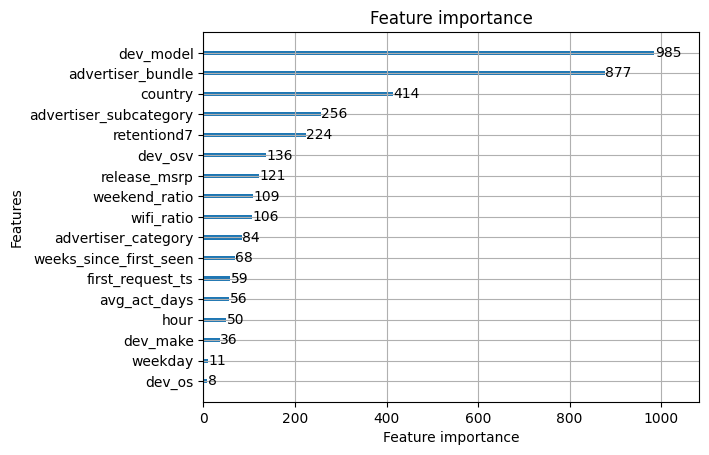

: 

In [ ]:
# Evaluar en validación
pred_log = model.predict(X_val)
pred_val = np.expm1(pred_log).clip(0, None)
msle = mean_squared_log_error(y_val, pred_val)
print(f"MSLE en validación: {msle}")

# Feature importance
lgb.plot_importance(model, max_num_features=20)